# The Full, Running Example for the Defense

Change up to the main repo directory:

In [1]:
import os
os.chdir(os.path.join('..', '..'))

In [2]:
%load_ext autoreload
%autoreload 2
import gym
from IPython.display import Video
from sklearn.model_selection import train_test_split

from wombats.systems import (StaticMinigridTSWrapper,
                             LavaComparison_noDryingOff)
from wombats.automaton import active_automata
from wombats.automaton import MinigridTransitionSystem
from wombats.learning import FlexfringeInterface
from wombats.automaton import Automaton
from wombats.utils import get_experiment_paths

# setting all paths
EXPERIMENT_NAME = 'simple_running_example'
ENV_ID = 'MiniGrid-MyDistShift-v0'

path_data = get_experiment_paths(EXPERIMENT_NAME)
EXPERIMENT_DIR = path_data['EXPERIMENT_DIR']
PDFA_MODEL_CONFIG_FILE = path_data['PDFA_MODEL_CONFIG_FILE']
LEARNER_DATA_DIR = path_data['LEARNER_DATA_DIR']
LEARNING_TRAIN_DATA_REL_FILEPATH = path_data['LEARNING_TRAIN_DATA_REL_FILEPATH']
LEARNING_TEST_DATA_REL_FILEPATH = path_data['LEARNING_TEST_DATA_REL_FILEPATH']
GYM_MONITOR_LOG_DIR = path_data['GYM_MONITOR_LOG_DIR']

# reset the kernel's Automata class' experimental directory for all created
# Automaton objects.
#
# If you autoreload any code having to do with the automaton, then you will
# need to re-run this cell to get the right automaton data path back, as the
# reload will reset the base Automaton class' automata_data_dir property
Automaton.automata_data_dir = os.path.join(EXPERIMENT_DIR)

In [3]:
path_data

{'EXPERIMENT_DIR': 'experiments/simple_running_example',
 'PDFA_MODEL_CONFIG_FILE': 'wombats/config/PDFA_simple_running_example.yaml',
 'TS_MODEL_CONFIG_FILE': 'wombats/config/TS_simple_running_example.yaml',
 'GYM_MONITOR_LOG_DIR': 'experiments/simple_running_example/minigrid_env_logs',
 'LEARNER_DATA_DIR': 'experiments/simple_running_example/flexfringe_data',
 'LEARNING_TRAIN_DATA_REL_FILEPATH': 'flexfringe_data/simple_running_example_train',
 'LEARNING_TEST_DATA_REL_FILEPATH': 'flexfringe_data/simple_running_example_test'}

## Loading in the Specification

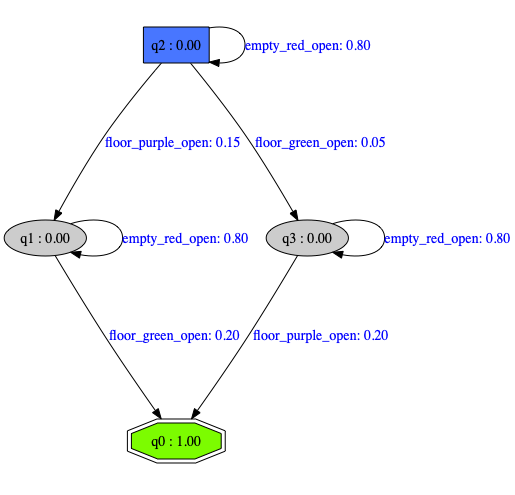

In [4]:
pdfa_specification = active_automata.get(automaton_type='PDFA',
                                         graph_data=PDFA_MODEL_CONFIG_FILE)

pdfa_specification.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'PDFA']))

In [7]:
num_samples = 1000
max_trace_length = 20
(traces,
 trace_lengths,
 trace_probs) = pdfa_specification.generate_traces(num_samples, N=max_trace_length)

# create a training-test split for model validation after training 
test_size = 0.99
(traces_train, traces_test,
 traceLengths_train, traceLengths_test,
 trace_probs_train, trace_probs_test) = train_test_split(traces,
                                                         trace_lengths,
                                                         trace_probs,
                                                         test_size=test_size)

# Write learning data to files for inference
train_data_file = pdfa_specification.write_traces_to_file(
    traces_train,
    alphabet_size=pdfa_specification.alphabet_size,
    file=LEARNING_TRAIN_DATA_REL_FILEPATH)
test_data_file = pdfa_specification.write_traces_to_file(
    traces_test,
    alphabet_size=pdfa_specification.alphabet_size,
    file=LEARNING_TEST_DATA_REL_FILEPATH)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0781s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0494s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  1

In [8]:
flexfringe = FlexfringeInterface(output_directory=LEARNER_DATA_DIR)

welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.4 --output-dir=experiments/simple_running_example/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/simple_running_example/flexfringe_data/simple_running_example_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running x16  m99976  m99966  x12  m99961  x5  m99977  m99974  x4  x4  x2  x1  

found intermediate solution with 8 and 8 red states
No valid solver specified, skipping.

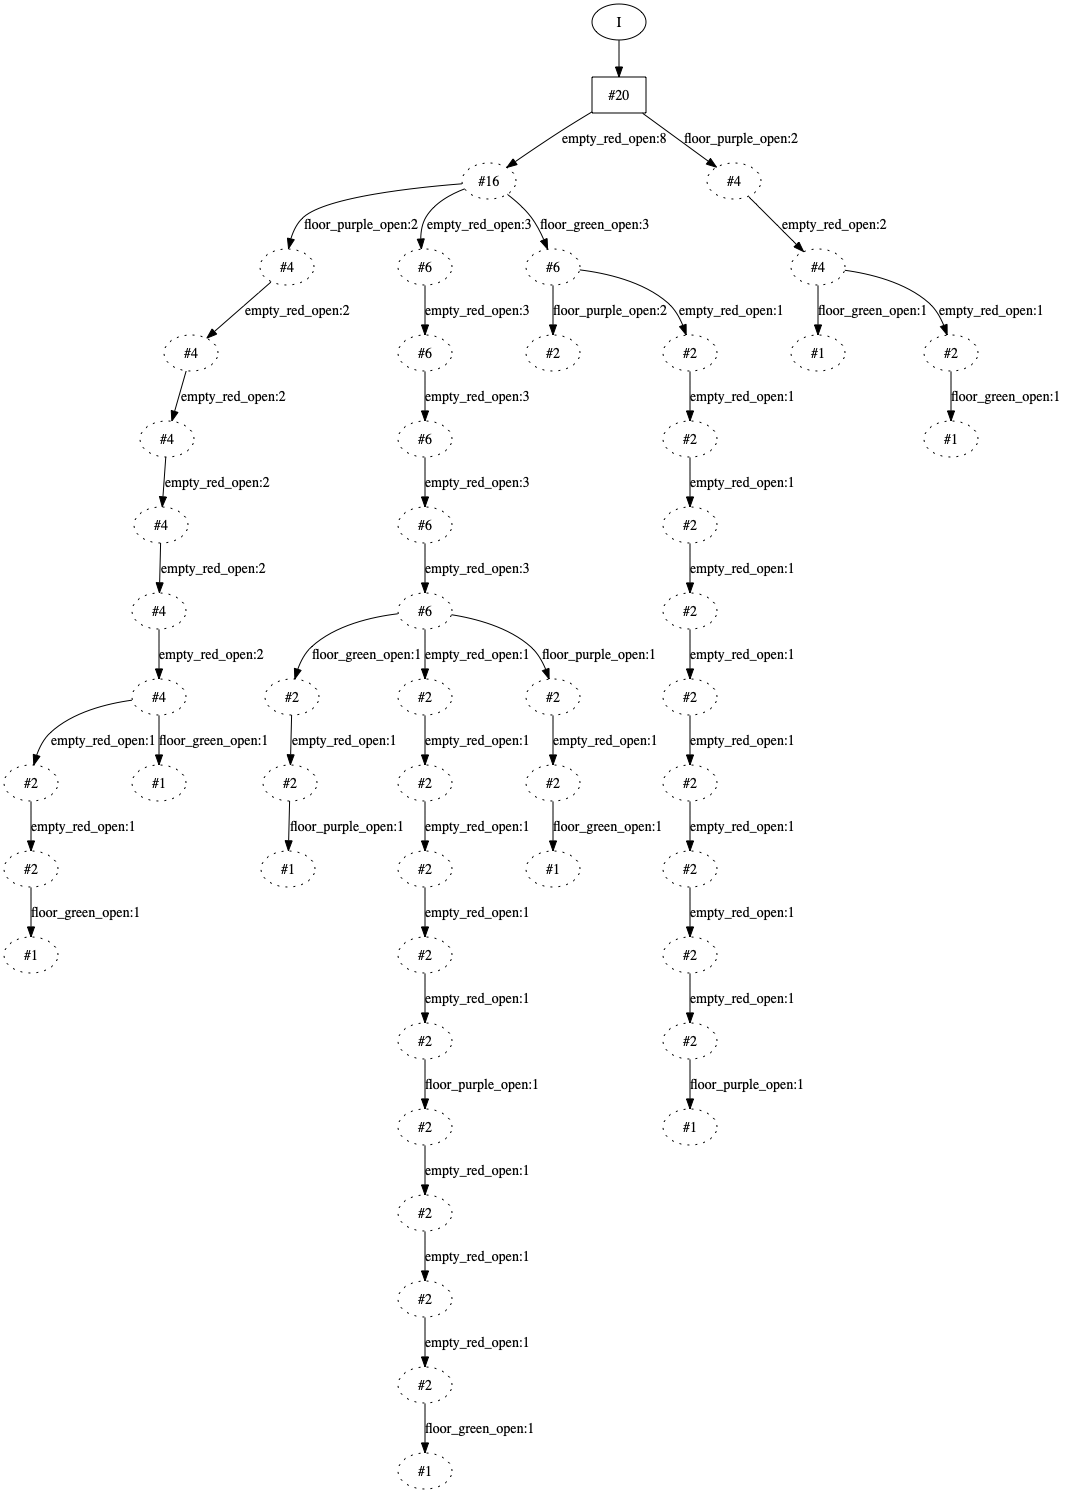

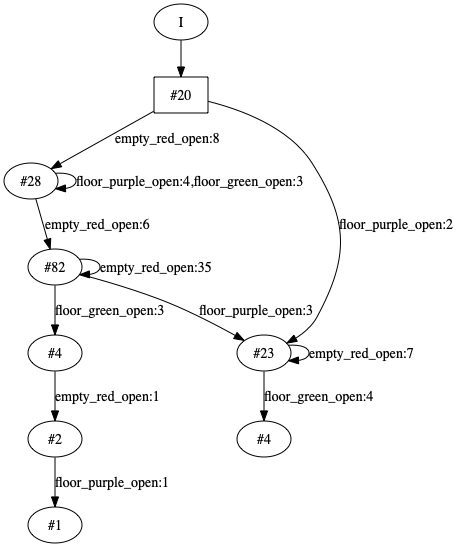

In [9]:
data = flexfringe.infer_model(training_file=train_data_file,
                              h='kldistance', #  --heuristic-name
                              d='kl_data',  # --data-name
                              m='2',  # --method
                              n='2',  # --runs
                              x='0',  # --extend
                              w='0',  # --shallowfirst
                              a='0',  # --largestblue
                              b='0',  # --blueblue
                              f='0',  # --finalred
                              I='1',  # --sinkson
                              t='1',  # --testmerge
                              q='0',  # --state_count
                              y='0',  # --symbol_count
                              p='0.4')  # --extrapar
flexfringe.draw_initial_model()
flexfringe.draw_learned_model()

In [10]:
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_2.dot'))
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_3.dot'))
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_4.dot'))
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_5.dot'))
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_6.dot'))
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_7.dot'))
# flexfringe.draw_IPython(flexfringe._read_model_data('meowmix_8.dot'))

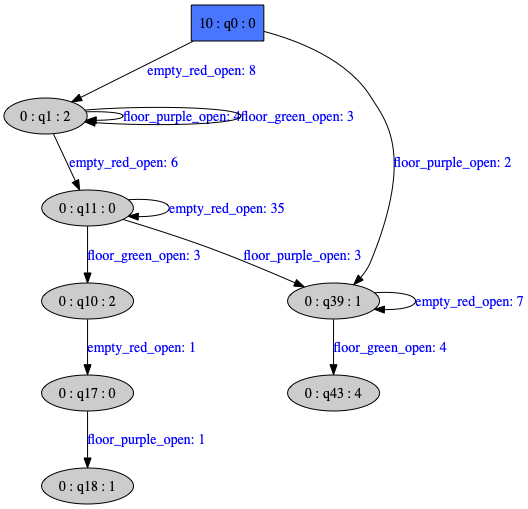

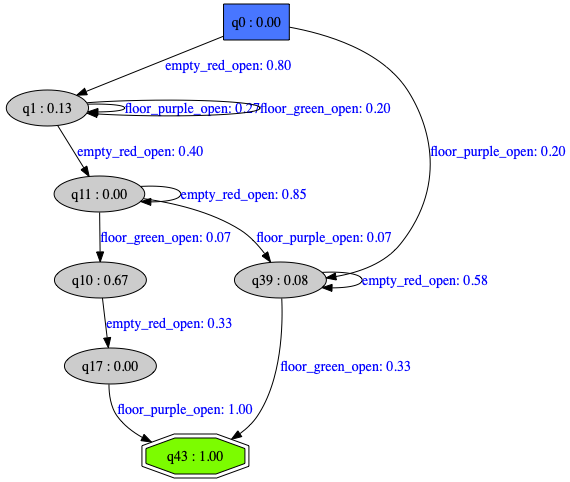

In [11]:
learned_fdfa = active_automata.get(automaton_type='FDFA',
                                   graph_data=flexfringe,
                                   graph_data_format='learning_interface')
learned_fdfa.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'learned', 'FDFA']))

learned_pdfa = active_automata.get(automaton_type='PDFA',
                                   graph_data=learned_fdfa,
                                   graph_data_format='fdfa_object',
                                   merge_sinks=True)
learned_pdfa.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'learned', 'PDFA']))

In [12]:
(specification_MPS,
 specification_MPS_prob, _) = pdfa_specification.most_probable_string()
print(f'Specification MPS: {specification_MPS}')
print(f'Probability of Spec. MPS in PDFA"s Language: {specification_MPS_prob}')

learned_model_MPS, learned_model_MPS_prob, _ = learned_pdfa.most_probable_string()
print(f'Learned MPS: {learned_model_MPS}')
print(f'Probability of Learned MPS in PDFA"s Language: {learned_model_MPS_prob}')


Specification MPS: ['floor_purple_open', 'floor_green_open']
Probability of Spec. MPS in PDFA"s Language: 0.03



Learned MPS: ['empty_red_open']
Probability of Learned MPS in PDFA"s Language: 0.10666666666666667


In [13]:
test_perplexity = learned_pdfa.perplexity(traces_test, trace_probs_test)
train_perplexity = learned_pdfa.perplexity(traces_train, trace_probs_train)
target_perplexity = pdfa_specification.perplexity(traces_test, trace_probs_test)

print(f"Test Perplexity of Learned Model: {test_perplexity}")
print(f"Training Perplexity of Learned Model: {train_perplexity}")
print(f"Perplexity of Target Model: {target_perplexity}")

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q0) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q10) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q17) transition distribution
  warnings.warn(str(e))


Test Perplexity of Learned Model: inf
Training Perplexity of Learned Model: 1.4095348361152156
Perplexity of Target Model: 3995448265054341.5


In [14]:
print(learned_pdfa.predictive_accuracy(test_traces=traces_test))
print(pdfa_specification.predictive_accuracy(test_traces=traces_test))

ValueError: given symbol (floor_green_open) is not found in the curr_state's (q0) transition distribution

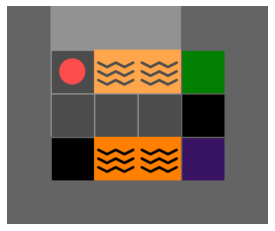

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)


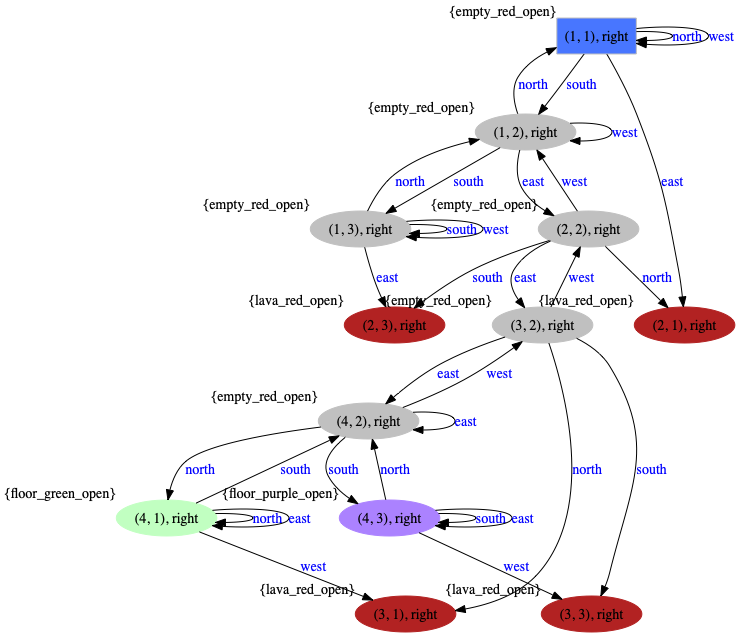

In [15]:
env = gym.make(ENV_ID)
env = StaticMinigridTSWrapper(env, actions_type='simple_static',
                              monitor_log_location=GYM_MONITOR_LOG_DIR)
env.reset()
env.render_notebook()

minigrid_TS = active_automata.get(automaton_type='TS', graph_data=env,
                                  graph_data_format='minigrid')
minigrid_TS.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'TS']))

In [16]:
minigrid_TS.observations

{'empty_red_open', 'floor_green_open', 'floor_purple_open', 'lava_red_open'}

In [17]:
list(minigrid_TS.actions)

[<SimpleStaticActions.north: 0>,
 <SimpleStaticActions.south: 1>,
 <SimpleStaticActions.east: 2>,
 <SimpleStaticActions.west: 3>]

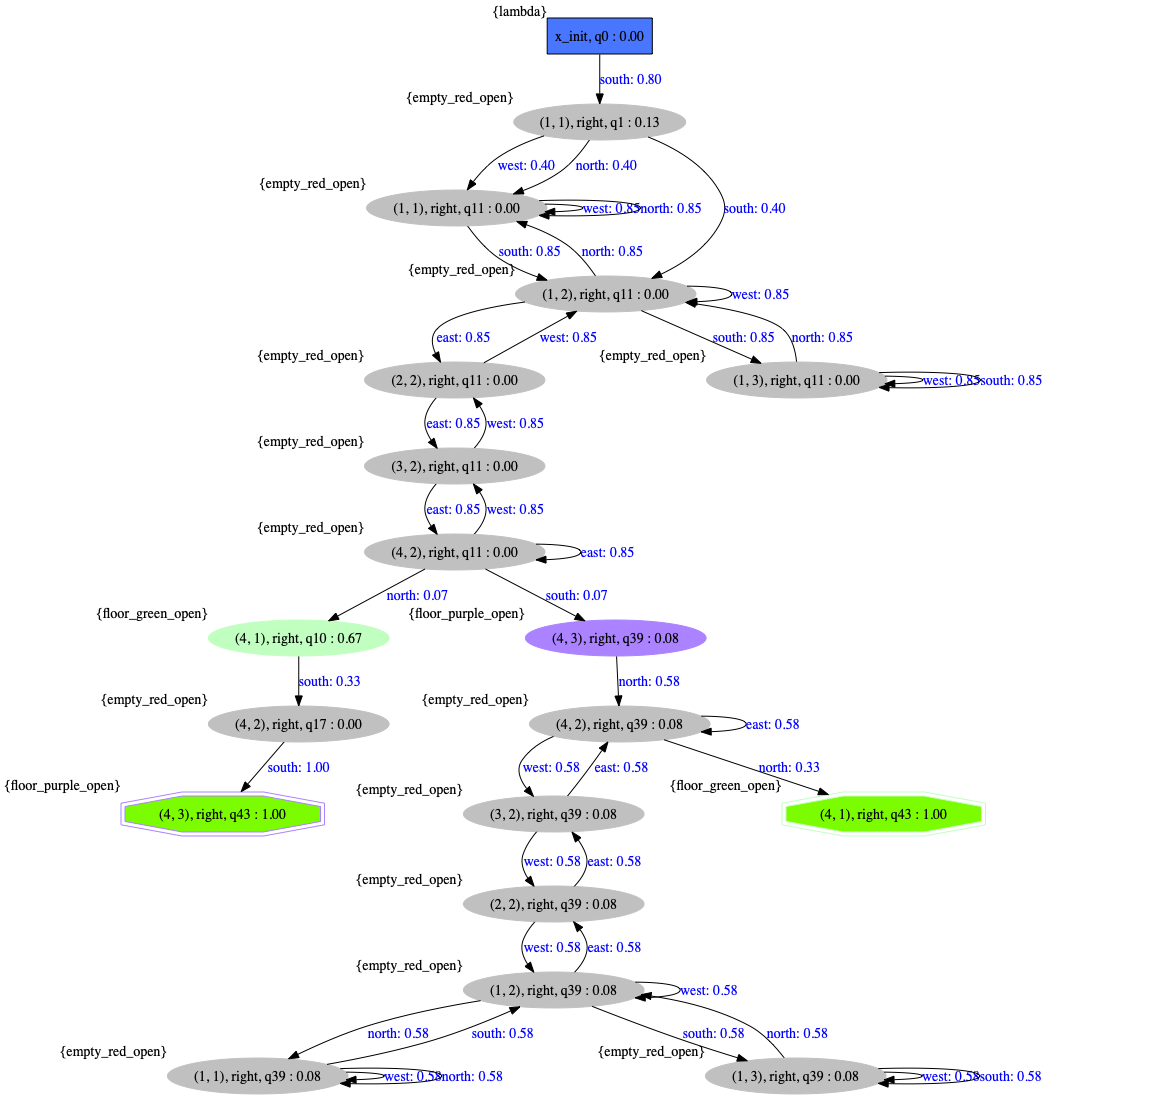

In [18]:
product = active_automata.get(automaton_type='Product',
                              graph_data=(minigrid_TS,
                                          learned_pdfa),
                             show_steps=False)
product.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'learned', 'product']))

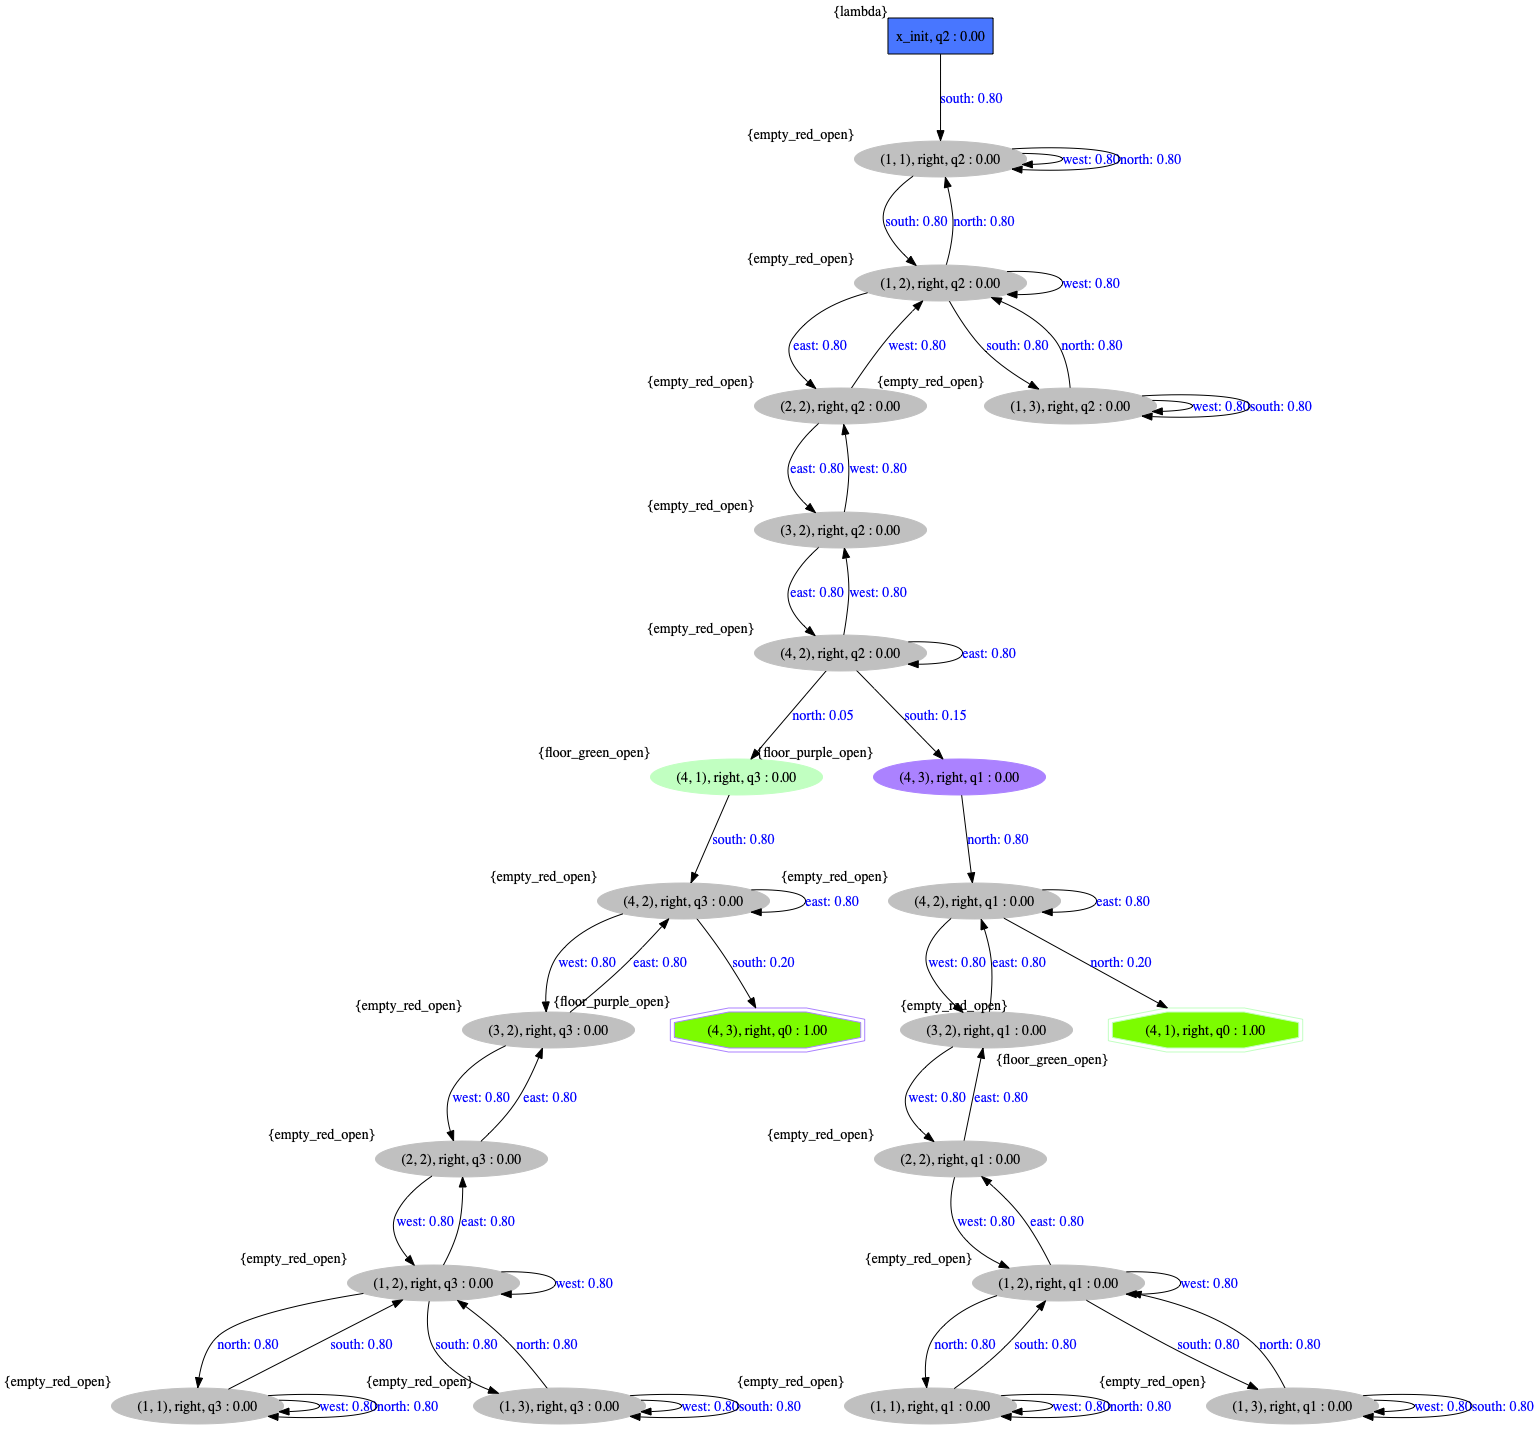

In [19]:
specified_product = active_automata.get(automaton_type='Product',
                              graph_data=(minigrid_TS,
                                          pdfa_specification),
                             show_steps=False)
specified_product.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'specified', 'product']))

In [19]:
product.observations

{'empty_red_open', 'floor_green_open', 'floor_purple_open', 'lambda'}

In [20]:
(controls,
 prob_of_controls_under_spec) = product.compute_strategy()

print(f'Optimal Controls: {controls}')
print(f'Probability of Generated TS Observations in Spec: ' +
      f'{prob_of_controls_under_spec}')


Optimal Controls: ['south', 'east', 'east', 'east', 'south', 'north', 'north']
Probability of Generated TS Observations in Spec: 0.007647546745651188


In [21]:
output_string, visited_states, video_path = minigrid_TS.run(controls,
                                                            record_video=True)
print(output_string)
print(visited_states)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")

['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_purple_open', 'empty_red_open', 'floor_green_open']
['(1, 1), right', '(1, 2), right', '(2, 2), right', '(3, 2), right', '(4, 2), right', '(4, 3), right', '(4, 2), right', '(4, 1), right']
